In [2]:
print("Hello")

Hello


In [3]:
import os
import zipfile
import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter

from torch.utils.data import Dataset, DataLoader

from PIL import Image

from torchvision import transforms

In [ ]:
from model_xception import my_xception

In [11]:
from pathlib import Path
import random

zip_folder_path = './handsign.zip'

local_extraction_path = './handsign_local'

if os.path.exists(local_extraction_path) is False:
  os.makedirs(local_extraction_path, exist_ok=True)

  with zipfile.ZipFile(zip_folder_path, 'r') as zip_ref:
    zip_ref.extractall(local_extraction_path)

  print(f"Items of {zip_folder_path} to {local_extraction_path}")
else:
  print("Already unzip")

import shutil

items = os.listdir(local_extraction_path)
for i in items:
  if(i == '__MACOSX'):
    shutil.rmtree(os.path.join(local_extraction_path, i))

items = os.listdir(local_extraction_path) # Refresh
print(items)

class_labels = ['thumbs-up', 'okay', 'peace', 'palm-up', 'palm-down']

def extract_images(PATH: Path):
    data = {}
    for dir in PATH.iterdir():
        if not dir.is_dir():
            continue

        print('Found Directory: ', dir)
        print('Extracting...')
        data[dir.name] = {}
        dir_dict = data[dir.name]

        img_path = dir / 'images'
        labels_path = dir / 'labels'

        if not img_path.is_dir() or not labels_path.is_dir():
            print(f"  Skipping {dir.name}: 'images' or 'labels' folder missing.")
            continue

        label_files = list(labels_path.glob('*.txt'))
        if not label_files:
            print(f"  No .txt label files found in {labels_path}")
            continue

        log = None
        for i, label_file in enumerate(label_files):
            file_stem = label_file.stem

            # Find the matching image (jpg, png, etc.)
            image_pth = next(img_path.glob(f'{file_stem}.*'), None)

            if image_pth is None: # If no matching image, skip
                continue

            try: # If label file is corrupt, skip
                with open(label_file, 'r') as f:
                    cls = int(f.read().split()[0])
            except Exception:
                continue

            if cls not in dir_dict.keys():
                dir_dict[cls] = []
            dir_dict[cls].append(image_pth)

            log = f'Building Data, Found : {i + 1} / {len(label_files)}'
            print(log, end='\r')

        if log:
            print(log) # Print final count
    return data

class HandSignsDataset(Dataset):
    """
    A custom dataset for a hand signs.
    """

    def __init__(self, data, transforms):
        """

        initializes the dataset from a dictionary in the format

        {
            class_0 : list_image_path
            ...
            class_N : list_image_path
        }
        """

        self.data = data
        self.transforms = transforms

        self.flat_data = [(img, cls) for cls, imgs in data.items() for img in imgs]

    def class_count(self):
        """
        returns the count of data for each class
        """

        for cls, data in self.data.items():

            print(f'class {cls} : {len(data)}')

    def __len__(self):
        """
        returns the
        """
        return len(self.flat_data)

    def __getitem__(self, index):
        """
        indexes self.flat_data, returns a transformed image and the class as a tensor
        """
        image_pth, cls = self.flat_data[index]
        image = Image.open(image_pth)
        transformed_image = self.transforms(image)

        return  transformed_image, torch.tensor(cls)
    
base_path = Path('./handsign_local')
data = extract_images(base_path)

Already unzip
['test', 'README.roboflow.txt', 'data.yaml', 'train', 'valid', 'README.dataset.txt']
Found Directory:  handsign_local/test
Extracting...
Building Data, Found : 1003 / 1003
Found Directory:  handsign_local/train
Extracting...
Building Data, Found : 7355 / 7355
Found Directory:  handsign_local/valid
Extracting...
Building Data, Found : 993 / 993


In [12]:
class Trainer:
  def __init__(self, model, train_loader, val_loader, criterion, optimizer, num_epochs=20, scheduler=None):

    #training device variables group
    self.device = 'cuda' if torch.cuda.is_available else 'cpu'

    self.model = model.to(self.device)

    #data loader variables group
    self.train_loader = train_loader
    self.val_loader = val_loader

    #training variables group
    self.criterion = criterion
    self.optimizer = optimizer
    self.num_epochs = num_epochs

    self.scheduler = scheduler

    #variabels for tracking and plotting
    self.train_losses = []
    self.val_losses = []
    self.train_accuracies = []
    self.val_accuracies = []

    # TensorBoard writer
    self.writer = SummaryWriter()

  """
  This iterates through each epochs to train the model
  it tracks train/val loss and accuracy
  This methods also write log for tensor board for result visulization and comparation
  """
  def fit(self):
    for epoch in range(self.num_epochs):
      train_loss, train_accuracy = self.train()
      val_loss, val_accuracy = self.evaluate()

      if self.scheduler:
                self.scheduler.step()

      # Store loss and accuracy values
      self.train_losses.append(train_loss)
      self.train_accuracies.append(train_accuracy)
      self.val_losses.append(val_loss)
      self.val_accuracies.append(val_accuracy)

      # Log metrics to TensorBoard
      self.writer.add_scalar('Loss/Train', train_loss, epoch)
      self.writer.add_scalar('Loss/Validation', val_loss, epoch)
      self.writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
      self.writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)
      print(f'Epoch [{epoch+1}/{self.num_epochs}], '
            f' Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%,'
            f' Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    self.writer.close() # Close the writer after training is complete

  """
  This class mode the model on training mode, and uses running loss, correct predicting, and total samples
  to track the loss and accuracy of the model

  The main thing of this method is the gradient calculation
  This basically adjusting the (w,b), so for example, y = aw+b. We are finding the best set of (w,b)
  Then, next time a is enterd, the y will be calculated.

  before doing something, we first cleaning the preivous gradient and calculate the new ones
  """
  def train(self):
    run_loss = 0.0
    correct_pred = 0
    total_samples = 0

    self.model.train()  # Set model to training mode

    for images, labels in self.train_loader:
      images, labels = images.to(self.device), labels.to(self.device)

      self.optimizer.zero_grad()
      outputs = self.model(images)
      loss = self.criterion(outputs, labels)
      loss.backward()
      self.optimizer.step()

      # Track loss and accuracy
      run_loss += loss.item()
      _, predicted = torch.max(outputs, 1)
      correct_pred += (predicted == labels).sum().item()
      total_samples += labels.size(0)

    # Calculate training loss and accuracy
    train_loss = run_loss / len(self.train_loader)
    train_accuracy = correct_pred / total_samples * 100

    return train_loss, train_accuracy

  """
  This method is used for evaludating the model,
  the main role of this one is
  after training, we will to evaluate it in order to fine-tune it
  Therefore, in this method, there is no gradient calculation
  """
  @torch.no_grad()
  def evaluate(self):
    val_loss = 0.0
    correct_pred = 0
    total_samples = 0

    self.model.eval()  # Set model to evaluation mode
    for images, labels in self.val_loader:
      images, labels = images.to(self.device), labels.to(self.device)

      # Forward pass
      outputs = self.model(images)
      loss = self.criterion(outputs, labels)
      val_loss += loss.item()

      # Track accuracy
      _, predicted = torch.max(outputs, 1)
      correct_pred += (predicted == labels).sum().item()
      total_samples += labels.size(0)

    # Calculate validation loss and accuracy
    val_loss = val_loss / len(self.val_loader)
    val_accuracy = correct_pred / total_samples * 100

    return val_loss, val_accuracy

  def save_model(self, path):
    print(f'Saving {self.model} to {path}')
    with open(path, 'wb') as f:
      pickle.dump(self.model, f)

In [13]:
from torchvision import transforms

IMG_size = 299

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_size),
    transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    # transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

testVal_transform = transforms.Compose([
    transforms.transforms.Resize(IMG_size),
    transforms.CenterCrop(IMG_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_set = HandSignsDataset(data['train'], train_transform)
test_set = HandSignsDataset(data['test'], testVal_transform)
val_set = HandSignsDataset(data['valid'], testVal_transform)

batch_size = 32
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

print("DataLoader objects created successfully.")

DataLoader objects created successfully.


In [14]:
def show_img(path):

    return Image.open(path)
show_img(data['test'][0][0])

In [15]:
output_dim = 5

xception = my_xception(output_dim, lr=1e-4)

if torch.cuda.is_available():
    xception.cuda()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
trainable_params = filter(lambda p: p.requires_grad, xception.parameters())
optimizer = optim.Adam(trainable_params, lr=1e-4)

xception_trainer = Trainer(xception, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=15)
xception_trainer.fit()

Epoch [1/15],  Train Loss: 1.2812, Train Accuracy: 47.00%, Val Loss: 0.7932, Val Accuracy: 72.21%
Epoch [2/15],  Train Loss: 0.9082, Train Accuracy: 66.28%, Val Loss: 0.6983, Val Accuracy: 75.73%
Epoch [3/15],  Train Loss: 0.7285, Train Accuracy: 73.43%, Val Loss: 0.4268, Val Accuracy: 88.82%
Epoch [4/15],  Train Loss: 0.6144, Train Accuracy: 77.87%, Val Loss: 0.3024, Val Accuracy: 91.74%
Epoch [5/15],  Train Loss: 0.5471, Train Accuracy: 80.37%, Val Loss: 0.3422, Val Accuracy: 90.23%
Epoch [6/15],  Train Loss: 0.5026, Train Accuracy: 82.01%, Val Loss: 0.2680, Val Accuracy: 94.46%
Epoch [7/15],  Train Loss: 0.4665, Train Accuracy: 83.52%, Val Loss: 0.2304, Val Accuracy: 94.66%
Epoch [8/15],  Train Loss: 0.4330, Train Accuracy: 84.27%, Val Loss: 0.1892, Val Accuracy: 95.17%
Epoch [9/15],  Train Loss: 0.4320, Train Accuracy: 85.08%, Val Loss: 0.2760, Val Accuracy: 93.05%
Epoch [10/15],  Train Loss: 0.4140, Train Accuracy: 85.23%, Val Loss: 0.2230, Val Accuracy: 95.07%
Epoch [11/15],  Tra

In [16]:
def plot_afterTraining(trainer_name, model_name, save_path):
  epochs = range(1, trainer_name.num_epochs + 1)
  plt.figure(figsize=(12, 5))

  plt.suptitle(model_name)

  loss_plot(epochs, trainer_name)
  accuracy_plot(epochs, trainer_name)

  plt.tight_layout()

  model_name += '-curves'

#   full_save = os.path.join(save_path, model_name)

#   plt.savefig(full_save)
  plt.show()
  plt.close()

def loss_plot(epochs, trainer_name):
  plt.subplot(1, 2, 1)
  plt.plot(epochs, trainer_name.train_accuracies, 'b', label='Training accuracy')
  plt.plot(epochs, trainer_name.val_accuracies, 'r', label='Validation accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy (%)')
  plt.legend()

def accuracy_plot(epochs, trainer_name):
  plt.subplot(1, 2, 2)
  plt.plot(epochs, trainer_name.train_losses, 'b', label='Training loss')
  plt.plot(epochs, trainer_name.val_losses, 'r', label='Validation loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

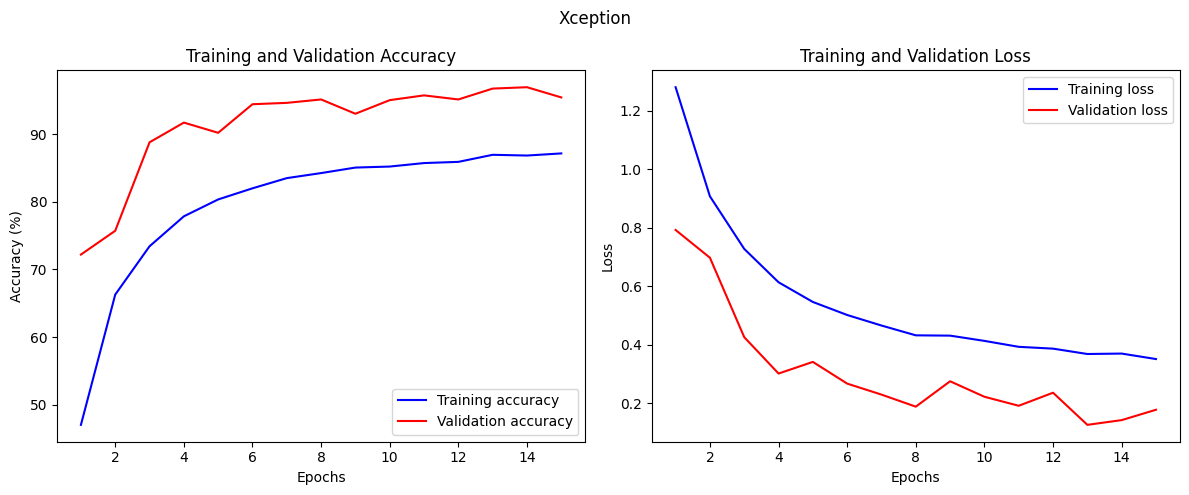

In [17]:
plot_afterTraining(xception_trainer, "Xception", "../..")